# Unsupervised Clustering of Board Game Reviews

_Ryan Harper_

In [4]:
import random
import numpy as np
from string import punctuation as punct
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import v_measure_score
from sklearn.feature_extraction.text import TfidfVectorizer

# for mac only: frog,blow,funk,glass,tink,submarine,purr,sosumi
def beep(audio): 
    os.system('afplay /System/Library/Sounds/' + audio +'.aiff')

# 1. Import and Clean Data

In [5]:
import pandas as pd

boardgamereviews = pd.read_csv('../../data/boardgame/boardgame-comments-english.csv')
boardgamereviews.columns = 'reviewer_id', 'game_id', 'rating', 'comment'
unique_id = boardgamereviews.reviewer_id.unique()
sample_id = random.sample(unique_id.tolist(),2000)
review = boardgamereviews[boardgamereviews['reviewer_id'].isin(sample_id)]

#### _Ratings equal the difference between a user's rating and that user's average rating._

In [6]:
review['rating_normed'] = review.rating - review['rating'].groupby(review['reviewer_id']).transform('mean')
review['rating_normed']= (review['rating_normed']-review['rating_normed'].min())/(review['rating_normed'].max()-review['rating_normed'].min())
# review['estimate'] = review['rating_normed'] + review['rating'].groupby(review['reviewer_id']).transform('mean')

# 2. Visualize

#### _The ratings appear normalized after reviews are adjusted according to user specific ratings_

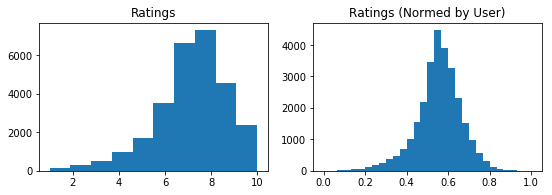

In [7]:
plt.figure(figsize=(9,6))
plt.subplot(2,2,1)
plt.hist(review.rating,bins=10)
plt.title('Ratings')

plt.subplot(2,2,2)
plt.hist(review.rating_normed,bins=30)
plt.title('Ratings (Normed by User)');

In [8]:
from string import punctuation
# Functions for finding percentage frequency (capital letters/punctuation)
def per_check(string_value, total):
    percentage = len(string_value)
    if percentage != 0:
        percentage = float(total / percentage) * 100
    else:
        percentage = 0
    return percentage

def punc_count(string_value):
    count = 0
    for c in string_value:
        if c in punctuation:
            count+= 1
    return per_check(string_value, count)

def caplet_count(string_value):
    count = 0
    for c in string_value:
        if c.isupper():
            count+= 1
    return per_check(string_value, count)      

review['c_len'] = review.comment.apply(len)
review['punc_count'] = review.comment.apply(punc_count)
review['caplet_count'] = review.comment.apply(caplet_count)

## _TextBlob_

In [9]:
%%time
import textblob
blobs = review.comment.apply(lambda val: textblob.TextBlob(val))

CPU times: user 481 ms, sys: 85.2 ms, total: 566 ms
Wall time: 674 ms


In [10]:
review['sent_pol'] = blobs.apply(lambda val: val.sentiment[0])
review['sent_subj'] = blobs.apply(lambda val: val.sentiment[1])

# 3. Tokenize

In [11]:
%%time
import re
only_chars = r'[^\w\s]'
review['tokens'] = review.comment.apply(lambda val: re.sub(only_chars,'',val).lower().split(' '))
beep('submarine')

CPU times: user 530 ms, sys: 32.6 ms, total: 563 ms
Wall time: 2.51 s


In [12]:
review.head()

,reviewer_id,game_id,rating,comment,rating_normed,c_len,punc_count,caplet_count,sent_pol,sent_subj,tokens
30,97646,143884,8.5,A deck building game that is packed full micro...,0.604287,334,2.395210,1.497006,0.078571,0.635714,"[a, deck, building, game, that, is, packed, fu..."
42,168821,143884,8.5,"Simple rules, fast paced and fun to play 30-45...",0.603199,50,4.000000,2.000000,0.166667,0.385714,"[simple, rules, fast, paced, and, fun, to, pla..."
46,108074,822,7.5,My wife loves this one and non gaming friends ...,0.525531,82,0.000000,1.219512,0.000000,0.000000,"[my, wife, loves, this, one, and, non, gaming,..."
51,152020,173,8.0,"Surprisingly good, if you're in the mood for a...",0.613856,136,4.411765,2.205882,0.440000,0.610000,"[surprisingly, good, if, youre, in, the, mood,..."
54,105468,173,8.0,"Two laps only (three tends to drag), but a gre...",0.563069,69,5.797101,1.449275,0.075000,0.555208,"[two, laps, only, three, tends, to, drag, but,..."


In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec_tfid = TfidfVectorizer(stop_words='english',min_df=10,smooth_idf=True)
vec_tfid.fit(review.comment)
beep('submarine')
review['tfidf'] = review.comment.apply(lambda val: vec_tfid.transform([val]).toarray()).apply(lambda val: val[0])
review['tfidf_length'] = review.tfidf.apply(len)
beep('submarine')

# 4. Vectorize

__Cosine Similarity Function__

$$ cos(\theta) = \frac{A \bullet B} {\Vert A \Vert \Vert B \Vert} =  \frac{\sum_{i=1}^n A_i B_i}{\sqrt{ \sum_{i=1}^n A^2} \sqrt{ \sum_{i=1}^n B^2}} $$

_Version A. Raw Code_

#### _Used the cosine similarity function to check common words. 'Easy' and 'Simple' appear to be much more similar than 'Cat'.<br> <br>A good sign that the vectorization worked!_

# 4. Models

In [84]:
%%time
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=100)
X = pd.DataFrame(tsvd.fit_transform([i for i in review.tfidf.tolist()]))
y = review['rating']

X_train_tsvd, X_test, y_train, y_test = train_test_split(X, y.astype(int).ravel(), test_size=0.33, random_state=42)

beep('submarine')

CPU times: user 10.9 s, sys: 1.42 s, total: 12.4 s
Wall time: 9.51 s


#### _I would normally spend more time evaluating the PCA component reduction, but for this project I want to evaluate cluster performance_

### _K Means Clustering_

In [85]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [86]:
%%time
km_range = range(3,15)
km_predict = []
for i in km_range:
    # Declare and fit the model.
    km_predict.append(KMeans(n_clusters=i, random_state=42).fit_predict(X_train_tsvd))

    #Predicted clusters.
    print('{} completed'.format(i),end=' | ')

3 completed | 4 completed | 5 completed | 6 completed | 7 completed | 8 completed | 9 completed | 10 completed | 11 completed | 12 completed | 13 completed | 14 completed | CPU times: user 54.2 s, sys: 5.18 s, total: 59.4 s
Wall time: 29.9 s


### _Spectral Clustering_

# 5. Evaluate

## _V-Measurement Test_

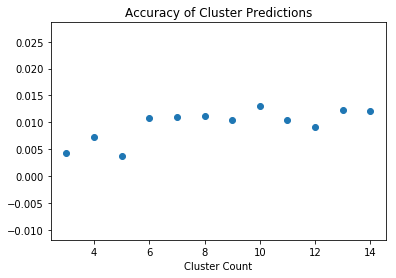

In [87]:
plt.scatter(x=[km_range],y=[v_measure_score(y_train,v) for v in km_predict])
plt.title('Accuracy of Cluster Predictions')
plt.xlabel('Cluster Count')

plt.show()

In [17]:
pd.crosstab(y_train, km_predict[8])

col_0,0,1,2,3,4,5,6,7,8,9,10
row_0,,,,,,,,,,,
1,4,14,0,74,3,1,0,0,12,3,1
2,13,37,0,136,8,5,0,1,24,6,3
3,26,100,1,242,11,19,1,2,45,12,8
4,44,127,5,378,24,28,2,8,77,12,12
5,86,271,18,749,52,82,6,21,133,40,26
6,172,527,47,1372,223,262,10,87,280,138,95
7,266,800,86,2230,457,500,52,204,490,218,207
8,281,675,102,2151,270,348,68,304,380,151,176
9,130,333,64,1207,85,119,65,176,204,75,59


In [18]:
from sklearn.metrics import adjusted_rand_score

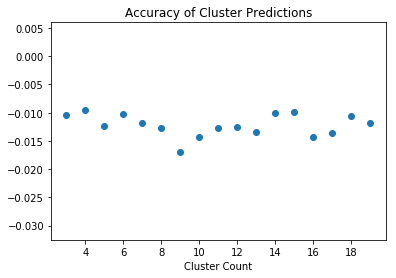

In [20]:
plt.scatter(x=[km_range],y=[adjusted_rand_score(y_train,v) for v in km_predict])
plt.title('Accuracy of Cluster Predictions')
plt.xlabel('Cluster Count')
# plt.ylim(0,.01)
plt.show()